In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import time

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


In [4]:
batch_size = 50
learning_rate = 0.0001
epoch_num = 15


In [5]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))


100.0%


Extracting ./data/02/MNIST/raw/train-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100.0%


Extracting ./data/02/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/02/MNIST/raw



100.0%


Extracting ./data/02/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/02/MNIST/raw



100.0%

Extracting ./data/02/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/02/MNIST/raw

number of training data :  60000
number of test data :  10000


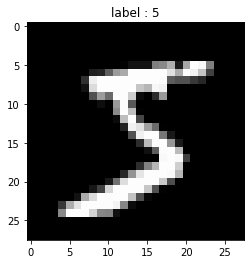

In [13]:
image, label = train_data[0]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()


In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size, shuffle = True)
first_batch = train_loader.__iter__().__next__()


In [15]:
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding='same')
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding='same')
        self.dropout = nn.Dropout2d(0.25)
        # (입력 뉴런, 출력 뉴런)
        self.fc1 = nn.Linear(3136, 1000)  # 7 * 7 * 64 = 3136
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [17]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [24]:
start = time.time()
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
        i += 1

Train Step : 1000	Loss : 0.021449
time : 75.77419805526733
Train Step : 2000	Loss : 0.001583
time : 150.76435208320618
Train Step : 3000	Loss : 0.000089
time : 219.04994583129883
Train Step : 4000	Loss : 0.004196
time : 289.4126079082489
Train Step : 5000	Loss : 0.001993
time : 358.4298617839813
Train Step : 6000	Loss : 0.004812
time : 426.2618980407715
Train Step : 7000	Loss : 0.006079
time : 493.00735902786255
Train Step : 8000	Loss : 0.072838
time : 561.8918709754944
Train Step : 9000	Loss : 0.001151
time : 631.734169960022
Train Step : 10000	Loss : 0.011187
time : 706.9281086921692
Train Step : 11000	Loss : 0.003400
time : 771.4183769226074


KeyboardInterrupt: 

In [23]:
model.eval()    # 평가시에는 dropout이 OFF 된다.
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy : 99.04%
